# Network Intrustion Detection

Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  The intrusion detector learning task is to build a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good (normal) connections. Here we use a Machine Learning multi-class classification model for the purpose.

## Library Imports

In [46]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [48]:
# seed for random number generator
SEED = 1234

## Exploratory Data Analysis

### Basic Information

In [49]:
# read data from Excel spreadsheet into data frame
raw = pd.read_excel('Sample Data.xlsx')
raw.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,diff_level
0,0,tcp,http,SF,350,2597,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11,34,0.00,0.0,0.00,0.0,1.00,0.00,0.09,11,255,1.00,0.00,0.09,0.03,0.00,0.0,0.00,0.0,normal,21
1,0,tcp,csnet_ns,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,23,1.00,1.0,0.00,0.0,0.08,0.04,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.0,0.00,0.0,neptune,20
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,85,0.00,0.0,0.00,0.0,1.00,0.00,0.00,255,85,0.33,0.02,0.33,0.00,0.00,0.0,0.00,0.0,smurf,18
3,0,tcp,other,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.05,0.0,0.95,1.0,satan,20
4,38736,tcp,private,RSTR,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,1.00,1.0,1.00,0.00,0.00,255,2,0.01,0.51,1.00,0.00,0.00,0.0,1.00,1.0,portsweep,15


In [50]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50389 entries, 0 to 50388
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     50389 non-null  int64  
 1   protocol_type                50389 non-null  object 
 2   service                      50389 non-null  object 
 3   flag                         50389 non-null  object 
 4   src_bytes                    50389 non-null  int64  
 5   dst_bytes                    50389 non-null  int64  
 6   land                         50389 non-null  int64  
 7   wrong_fragment               50389 non-null  int64  
 8   urgent                       50389 non-null  int64  
 9   hot                          50389 non-null  int64  
 10  num_failed_logins            50389 non-null  int64  
 11  logged_in                    50389 non-null  int64  
 12  num_compromised              50389 non-null  int64  
 13  root_shell      

In [51]:
raw.drop_duplicates(inplace=True)
print(raw.shape)

(50389, 43)


There are no null values and no duplicate observations.

In [52]:
# distribution of target variable: class, which indicates type of network intrusion or normal connection
raw['class'].value_counts()

normal             26884
neptune            16529
satan               1469
ipsweep             1464
portsweep           1180
smurf               1033
nmap                 601
warezclient          373
back                 364
teardrop             355
pod                   81
guess_passwd          15
buffer_overflow       10
warezmaster            6
land                   5
multihop               4
imap                   3
rootkit                3
ftp_write              3
loadmodule             3
spy                    2
perl                   2
Name: class, dtype: int64

In [53]:
# number of connection types (normal + attack)
raw['class'].nunique()

22

In [54]:
raw['protocol_type'].value_counts()

tcp     41124
udp      5946
icmp     3319
Name: protocol_type, dtype: int64

In [55]:
raw['service'].value_counts()

http         16169
private       8693
domain_u      3592
smtp          2863
ftp_data      2798
             ...  
urh_i            2
tim_i            2
tftp_u           1
http_8001        1
http_2784        1
Name: service, Length: 68, dtype: int64

In [56]:
raw['flag'].value_counts()

SF        29908
S0        13972
REJ        4511
RSTR        964
RSTO        630
S1          144
SH          112
S2           59
RSTOS0       40
S3           25
OTH          24
Name: flag, dtype: int64

In [57]:
raw.describe().round(4)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,diff_level
count,50389.0000,5.038900e+04,5.038900e+04,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0,50389.0,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000,50389.0000
mean,279.3522,8.160209e+04,1.070156e+04,0.0002,0.0226,0.0001,0.1948,0.0009,0.3961,0.3242,0.0013,0.0011,0.3409,0.0164,0.0004,0.0039,0.0,0.0,0.0090,84.0066,27.3709,0.2854,0.2832,0.1202,0.1214,0.6595,0.0633,0.0976,181.9598,115.4445,0.5209,0.0824,0.1476,0.0330,0.2849,0.2790,0.1189,0.1205,19.4967
std,2564.4011,8.691477e+06,1.784420e+06,0.0134,0.2527,0.0141,2.1032,0.0356,0.4891,35.0503,0.0364,0.0452,35.2051,0.5574,0.0218,0.0888,0.0,0.0,0.0945,114.3941,71.8916,0.4467,0.4473,0.3207,0.3238,0.4400,0.1809,0.2603,99.3907,110.7814,0.4492,0.1884,0.3076,0.1132,0.4449,0.4459,0.3067,0.3197,2.3084
min,0.0000,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0900,0.0000,0.0000,81.0000,10.0000,0.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18.0000
50%,0.0000,4.400000e+01,0.000000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,14.0000,8.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,255.0000,62.0000,0.5100,0.0300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000
75%,0.0000,2.740000e+02,5.250000e+02,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,143.0000,18.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0600,0.0000,255.0000,255.0000,1.0000,0.0700,0.0600,0.0200,1.0000,1.0000,0.0000,0.0000,21.0000
max,42837.0000,1.379964e+09,4.002911e+08,1.0000,3.0000,2.0000,77.0000,3.0000,1.0000,7479.0000,1.0000,2.0000,7468.0000,40.0000,2.0000,8.0000,0.0,0.0,1.0000,511.0000,511.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,255.0000,255.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,21.0000


Mean and variance of most features are very different. The values need to be standardized.

In [58]:
corr_df = raw.corr()
corr_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,diff_level
duration,1.000000,0.087284,0.069186,-0.001456,-0.009728,0.002072,0.006524,0.006361,-0.061084,0.024608,0.053672,0.079115,0.026019,0.109697,-0.001051,0.058402,NaN,NaN,0.001491,-0.078034,-0.038869,-0.069183,-0.068807,0.196254,0.194952,0.074507,-0.014769,-0.040198,0.050611,-0.107168,-0.114115,0.247285,0.221843,-0.025386,-0.063002,-0.062139,0.166606,0.193110,-0.156041
src_bytes,0.087284,1.000000,0.000805,-0.000125,-0.000837,-0.000079,0.000259,-0.000240,-0.004971,-0.000084,-0.000339,-0.000232,-0.000089,-0.000259,-0.000165,-0.000408,NaN,NaN,-0.000885,-0.006022,-0.003374,-0.003129,-0.003505,0.017215,0.017608,0.003794,0.000354,-0.003313,-0.006207,-0.008420,-0.008483,0.001289,-0.000079,-0.002290,-0.005262,-0.003451,-0.001713,0.016332,-0.026896
dst_bytes,0.069186,0.000805,1.000000,-0.000080,-0.000536,0.000148,-0.000242,-0.000003,-0.002377,0.003937,0.002157,0.002366,0.003942,0.000406,-0.000075,0.000691,NaN,NaN,-0.000443,-0.004306,-0.002097,-0.003685,-0.003663,0.011658,0.011533,0.004623,-0.002039,-0.001863,0.002214,-0.004371,-0.004414,0.009465,0.012639,-0.001388,-0.003677,-0.003587,0.012229,0.011727,-0.019256
land,-0.001456,-0.000125,-0.000080,1.000000,-0.001194,-0.000113,-0.001238,-0.000342,-0.010824,-0.000124,-0.000488,-0.000335,-0.000129,-0.000394,-0.000243,-0.000592,NaN,NaN,-0.001274,-0.008699,-0.004738,0.021382,0.021420,-0.005009,-0.005012,0.007001,-0.004021,0.040631,-0.024335,-0.013406,0.014255,-0.005843,0.037037,0.076103,0.021481,0.011953,-0.005181,-0.005037,-0.045337
wrong_fragment,-0.009728,-0.000837,-0.000536,-0.001194,1.000000,-0.000755,-0.008272,-0.002288,-0.072315,-0.000826,-0.003258,-0.002235,-0.000865,-0.002633,-0.001624,-0.003952,NaN,NaN,-0.008515,-0.021931,0.024228,-0.044999,-0.056548,-0.032981,-0.033485,0.056496,-0.026965,-0.026271,0.041033,-0.046306,-0.050369,0.050894,0.034808,-0.017081,-0.052224,-0.055869,0.025425,-0.033651,-0.156432


In [59]:
corr_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,diff_level
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,0.0,0.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.052934,0.028489,0.029774,0.029884,0.012377,0.033600,0.034917,0.027363,-0.037950,0.066945,0.065131,0.074712,0.068042,0.039666,0.030385,0.059845,NaN,NaN,0.031859,0.047581,0.013496,0.009663,0.008744,0.073210,0.073468,-0.029483,0.037937,0.004504,0.025509,-0.033709,-0.036377,0.060284,0.017687,0.016497,0.009457,0.009407,0.071331,0.073476,-0.017171
std,0.188182,0.164953,0.164432,0.165055,0.171230,0.165381,0.220521,0.165795,0.338046,0.230344,0.196473,0.204624,0.230832,0.166198,0.165812,0.186369,NaN,NaN,0.220326,0.317222,0.209845,0.415045,0.414693,0.347723,0.347771,0.409532,0.235509,0.228113,0.296366,0.365758,0.393682,0.257195,0.237306,0.226406,0.416127,0.416460,0.340346,0.346460,0.206016
min,-0.156041,-0.026896,-0.019256,-0.045337,-0.156432,-0.029893,-0.164934,-0.058844,-0.539558,-0.010047,-0.055745,-0.035249,-0.010416,-0.037948,-0.040556,-0.031241,NaN,NaN,-0.119780,-0.631154,-0.197826,-0.761537,-0.756022,-0.288341,-0.284843,-0.764474,-0.375481,-0.357485,-0.518326,-0.572728,-0.639554,-0.417177,-0.348409,-0.456331,-0.761283,-0.764474,-0.278496,-0.273257,-0.348409
25%,-0.040198,-0.003374,-0.002097,-0.005009,-0.033485,-0.003185,-0.033555,-0.009345,-0.273257,-0.003376,-0.012104,-0.006673,-0.003545,-0.009705,-0.006821,-0.014720,NaN,NaN,-0.034956,-0.066911,-0.108224,-0.224757,-0.226235,-0.100488,-0.100027,-0.209874,-0.023332,-0.078083,-0.024335,-0.247336,-0.257044,-0.016908,-0.035359,-0.055594,-0.227047,-0.226534,-0.098684,-0.086778,-0.100027
50%,0.006361,-0.000259,-0.000003,-0.000394,-0.003952,-0.000217,-0.008272,-0.001134,-0.008222,-0.000826,-0.000488,-0.000335,-0.000865,0.000168,-0.001734,-0.000408,NaN,NaN,-0.009618,-0.008699,-0.012104,-0.016908,-0.017018,-0.006641,-0.006673,0.007415,-0.005762,-0.012783,-0.001480,-0.022212,-0.008483,0.004333,-0.000079,-0.001388,-0.015483,-0.012949,-0.003588,-0.005037,-0.037948
75%,0.079115,0.000259,0.003942,0.007001,-0.000826,0.006541,0.003566,0.006361,0.045058,0.005951,0.045058,0.030906,0.006161,0.032224,0.001736,0.032713,NaN,NaN,-0.000885,0.174562,-0.003101,-0.003129,-0.003203,0.036424,0.033462,0.070282,0.048561,-0.001863,0.072148,-0.004371,0.014255,0.143674,0.035770,0.033462,0.002019,0.000667,0.044058,0.043126,-0.004197
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Features are not correlated.

## Data Cleaning

In [60]:
# remove useless features
# diff_level is a score of how difficult is it to classifiy the observation
# other two features have 0 variance

clean = raw.drop(['num_outbound_cmds', 'is_host_login', 'diff_level'], axis=1)

In [61]:
# group connection types into 5 major categories: normal(0), and 4 attack types as follows:
# probe(1), denial of service(DOS: 2), 
# user-to-root(U2R: 3), and remote-to-local(R2L: 4)

def connection_type(typ):
    label = ''
    if typ in ['satan', 'ipsweep', 'portsweep', 'nmap']:
        label = 1 # probe attack
    
    elif typ in ['neptune', 'smurf', 'back', 'teardrop', 'pod', 'land']:
        label = 2  # DOS attack
    
    elif typ in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl']:
        label = 3 # U2R attack
    
    elif typ in ['warezclient', 'guess_passwd', 'imap', 'warezmaster', 'multihop', 'ftp_write', 'spy']:
        label = 4 # R2L attack
        
    else:
        label = 0 # normal connection
    return label

In [62]:
clean['label'] = clean['class'].apply(connection_type)
clean.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,label
0,0,tcp,http,SF,350,2597,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,34,0.00,0.0,0.00,0.0,1.00,0.00,0.09,11,255,1.00,0.00,0.09,0.03,0.00,0.0,0.00,0.0,normal,0
1,0,tcp,csnet_ns,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,23,1.00,1.0,0.00,0.0,0.08,0.04,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.0,0.00,0.0,neptune,2
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,85,0.00,0.0,0.00,0.0,1.00,0.00,0.00,255,85,0.33,0.02,0.33,0.00,0.00,0.0,0.00,0.0,smurf,2
3,0,tcp,other,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.05,0.0,0.95,1.0,satan,1
4,38736,tcp,private,RSTR,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,1.00,1.0,1.00,0.00,0.00,255,2,0.01,0.51,1.00,0.00,0.00,0.0,1.00,1.0,portsweep,1


In [63]:
any((clean['class'] == 'normal') & (clean.label != 0))

False

In [64]:
clean.drop('class', axis=1, inplace=True)

In [65]:
clean.label.value_counts()

0    26884
2    18367
1     4714
4      406
3       18
Name: label, dtype: int64

Class distribution is imbalanced. We'll address this problem by using cost-sensitive learning, whereby a machine learning algorithm assigns penalty (error cost) proportionate to the class size. Thus, minority classes are assigned higher penalty for misclassification. This is done in order to prevent the class with large number of observations from skewing the performance results. 

In [66]:
# these numeric features represent binary values (0 or 1) and hence, are in fact categorical type
binary_features = ['land', 'logged_in', 'root_shell', 'is_guest_login']
clean[binary_features] = clean[binary_features].astype('category')
clean.dtypes

duration                          int64
protocol_type                    object
service                          object
flag                             object
src_bytes                         int64
dst_bytes                         int64
land                           category
wrong_fragment                    int64
urgent                            int64
hot                               int64
num_failed_logins                 int64
logged_in                      category
num_compromised                   int64
root_shell                     category
su_attempted                      int64
num_root                          int64
num_file_creations                int64
num_shells                        int64
num_access_files                  int64
is_guest_login                 category
count                             int64
srv_count                         int64
serror_rate                     float64
srv_serror_rate                 float64
rerror_rate                     float64


In [67]:
cat_features = ['protocol_type', 'service', 'flag']
clean[cat_features] = clean[cat_features].astype('category')
clean.dtypes

duration                          int64
protocol_type                  category
service                        category
flag                           category
src_bytes                         int64
dst_bytes                         int64
land                           category
wrong_fragment                    int64
urgent                            int64
hot                               int64
num_failed_logins                 int64
logged_in                      category
num_compromised                   int64
root_shell                     category
su_attempted                      int64
num_root                          int64
num_file_creations                int64
num_shells                        int64
num_access_files                  int64
is_guest_login                 category
count                             int64
srv_count                         int64
serror_rate                     float64
srv_serror_rate                 float64
rerror_rate                     float64


## Feature Engineering

In [68]:
cat_features = list(clean.select_dtypes(include=['category']))
print(cat_features)

['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell', 'is_guest_login']


In [69]:
# create binary dummy features for categorical variables (One-hot encoding)
df = pd.get_dummies(clean, columns=cat_features)
df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,...,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,root_shell_0,root_shell_1,is_guest_login_0,is_guest_login_1
0,0,350,2597,0,0,0,0,0,0,0,0,0,0,11,34,0.00,0.0,0.00,0.0,1.00,0.00,0.09,11,255,1.00,0.00,0.09,0.03,0.00,0.0,0.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,274,23,1.00,1.0,0.00,0.0,0.08,0.04,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.0,0.00,0.0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0
2,0,1032,0,0,0,0,0,0,0,0,0,0,0,85,85,0.00,0.0,0.00,0.0,1.00,0.00,0.00,255,85,0.33,0.02,0.33,0.00,0.00,0.0,0.00,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.05,0.0,0.95,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
4,38736,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,1.00,1.0,1.00,0.00,0.00,255,2,0.01,0.51,1.00,0.00,0.00,0.0,1.00,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0


In [70]:
# drop redundant dummy feature for binary (0-1) value features
df.drop(['land_0', 'logged_in_0', 'root_shell_0', 'is_guest_login_0'], axis=1, inplace=True)

In [71]:
df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,...,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_1,logged_in_1,root_shell_1,is_guest_login_1
0,0,350,2597,0,0,0,0,0,0,0,0,0,0,11,34,0.00,0.0,0.00,0.0,1.00,0.00,0.09,11,255,1.00,0.00,0.09,0.03,0.00,0.0,0.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,274,23,1.00,1.0,0.00,0.0,0.08,0.04,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.0,0.00,0.0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1032,0,0,0,0,0,0,0,0,0,0,0,85,85,0.00,0.0,0.00,0.0,1.00,0.00,0.00,255,85,0.33,0.02,0.33,0.00,0.00,0.0,0.00,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.05,0.0,0.95,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38736,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,1.00,1.0,1.00,0.00,0.00,255,2,0.01,0.51,1.00,0.00,0.00,0.0,1.00,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [72]:
df.shape

(50389, 119)

### Prepare Analytical Base Table

In [73]:
y = df['label']

In [74]:
X = df.loc[:, df.columns != 'label']

In [75]:
X.shape

(50389, 118)

In [76]:
# create train and test data sets using stratified sampling so that 
# classes are represented in both data sets in proportion to their size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

In [77]:
print(X_train.shape, y_train.shape)

(37791, 118) (37791,)


In [78]:
print(X_test.shape, y_test.shape)

(12598, 118) (12598,)


## Model Training

In [79]:
# create pipeline to first scale the data to have mean=0, stdev=1 and 
# then to instantiate the model
# Balanced class_weight implements cost-effective learning

pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(class_weight='balanced', random_state=SEED))


In [80]:
# train the model on training data set and evaluate its performance using 10-fold cross-validation

rfc = GridSearchCV(pipe, param_grid = {'randomforestclassifier__n_estimators': [100]}, cv=10)
rfc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=1234))]),
             param_grid={'randomforestclassifier__n_estimators': [100]})

In [81]:
# use ROC-AUC as it is better meric for performance evaluation (than accuracy) for imbalanced data sets
# use One-vs-One (ovo) multi-class classification scheme which is insensitive to class imbalance
  
# training AUC
y_train_prob = rfc.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_train_prob, average='weighted', multi_class='ovo')
    
# test AUC
y_test_prob = rfc.predict_proba(X_test)
auc_test = roc_auc_score(y_test, y_test_prob, average='weighted', multi_class='ovo')

# predicted connection type labels
y_pred = rfc.predict(X_test)


In [82]:
print('{0:s} training ROC-AUC: {1:.6f}\n'.format('Random Forest Classifier', auc_train))
print('{0:s} test ROC-AUC: {1:.6f}\n\n'.format('Random forest Classifier', auc_test))

Random Forest Classifier training ROC-AUC: 1.000000

Random forest Classifier test ROC-AUC: 0.999860




The model's test ROC-AUC score is excellent. Training and test scores are very close, indicating the model is not overfitting and is most likely to produce good predictions on unseen data.  

In [83]:
y_test_prob.shape

(12598, 5)

In [84]:
y_test_prob[:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [85]:
print(classification_report(y_test, y_pred, zero_division=0, 
                            target_names=['Normal', 'Probe', 'DOS', 'U2R', 'R2L']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6721
       Probe       1.00      0.99      1.00      1179
         DOS       1.00      1.00      1.00      4592
         U2R       1.00      0.25      0.40         4
         R2L       1.00      0.89      0.94       102

    accuracy                           1.00     12598
   macro avg       1.00      0.83      0.87     12598
weighted avg       1.00      1.00      1.00     12598



In [86]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Pred_Normal', 'Pred_Probe', 'Pred_DOS', 'Pred_U2R', 'Pred_R2L'], 
                         index=['True_Normal', 'True_Probe', 'True_DOS', 'True_U2R', 'True_R2L'])

cm_df['True_Total'] = cm_df.agg('sum', axis=1)
print(cm_df)

             Pred_Normal  Pred_Probe  Pred_DOS  Pred_U2R  Pred_R2L  True_Total
True_Normal         6718           2         1         0         0        6721
True_Probe             6        1173         0         0         0        1179
True_DOS               1           0      4591         0         0        4592
True_U2R               3           0         0         1         0           4
True_R2L              11           0         0         0        91         102


Almost all normal connections were predicted correctly. DOS and Normal attacks were predicted with 100% accuracy. R2L precision and recall are not perfect, but nonetheless excellent, with 98% of true R2L attacks were classified correctly. There were very few (only 4) U2R attack type observations in the test data set, and 3 were misclassified. Providing the model more samples of U2R and R2L attack types is likely to produce better prediction accuracy for these classes.

Both FPR (False Positive Rate) and TPR (True Positive Rate) are important metrics for this classification problem. While it is cruicial to identify a network attack (true positives), it is also important to not to classify a normal connection as an attack (false positives). Higher precision means fewer false positives. The classifier shows excellent performance on both TPR and FPR for all classes (except U2R) which is indicated by very high f1-score. (F1-score of 1.0 implies perfect classification.)

#### Find out which features are important for predicting the type of a network connection

In [87]:
importances = rfc.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

In [88]:
# get indices of top 10 features with highest importance
indices = np.argsort(importances)[:-10:-1]

In [89]:
# print top 10 most important features
print("Feature ranking:\n")

for f in indices:
    print("%s feature %d (%.3f)" % (X.columns[f], f, importances[f]))

Feature ranking:

dst_bytes feature 2 (0.077)
src_bytes feature 1 (0.075)
dst_host_srv_count feature 23 (0.067)
logged_in_1 feature 115 (0.044)
count feature 13 (0.043)
dst_host_diff_srv_rate feature 25 (0.041)
dst_host_same_src_port_rate feature 26 (0.040)
srv_count feature 14 (0.040)
dst_host_count feature 22 (0.037)


The three most important features for predicting the type of network connection as normal or intrusion are:
1. the number of bytes transferred from source to destination port and vice versa, and
2. number of connections to the same service as the current connection in the past two seconds

(Impurity-based feature importance is model-specific. It does not imply intrinsic ability of the feature to predict connection type.)

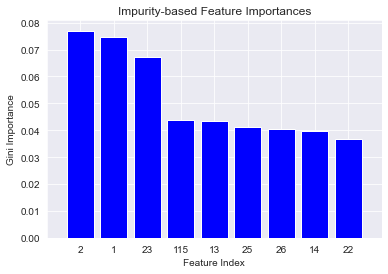

In [90]:
# Plot impurity-based feature importances of the model

plt.figure()
plt.title("Impurity-based Feature Importances")

plt.bar(range(len(indices)), importances[indices],
        color="blue", align="center")

plt.xlabel("Feature Index")
plt.ylabel("Gini Importance")

plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.show()